<a href="https://colab.research.google.com/github/CarsonSwa1/491CV-SuperResolution/blob/main/comp_vis_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K_train_HR.zip

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
from os import listdir
from tqdm import tqdm

In [ ]:
FIXED_0 = 1250
FIXED_1 = 2040

SHAPE_IN = (3,64,128,)
SHAPE_OUT = (3,128,256)

#Formating Data
training_data = []
for i, each in tqdm(enumerate(listdir("DIV2K_train_HR")),total = 800):
    img = cv2.imread(f'DIV2K_train_HR/{each}')
    if img.shape[0] == FIXED_1:
      img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    if img.shape[0] >= FIXED_0:
      #crop to a uniform size
      img = img[:FIXED_0,:,:]

      #get different size images
      img_x4 = cv2.resize(img, dsize = None, fx = .25, fy = .25, interpolation = cv2.INTER_CUBIC)
      img_x8 = cv2.resize(img_x4, dsize = None, fx = .502, fy = .502, interpolation = cv2.INTER_CUBIC)

      #get more sizes
      img_x8 = img_x8[:128,:,:]
      img_x16 = cv2.resize(img_x8, dsize = None, fx = .5, fy = .5, interpolation = cv2.INTER_CUBIC)

      #gets difference image
      img_add = img_x8 - cv2.resize(img_x16, dsize = None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)

      #convert to Tensor
      tensor_img_x16 = torch.from_numpy(img_x16)
      tensor_out = torch.from_numpy(img_add)
      tensor_lab = torch.from_numpy(img_x8)

      #convert to FloatTensor
      tensor_img_x16 = tensor_img_x16.type(torch.FloatTensor)
      tensor_out = tensor_out.type(torch.FloatTensor)
      tensor_lab = tensor_lab.type(torch.FloatTensor)

      #reshape
      tensor_img_x16 = torch.reshape(tensor_img_x16,SHAPE_IN)
      tensor_out = torch.reshape(tensor_out,SHAPE_OUT)
      tensor_lab = torch.reshape(tensor_lab,SHAPE_OUT)
      training_data.append((tensor_img_x16, tensor_lab))

100%|██████████| 800/800 [01:24<00:00,  9.47it/s]


In [ ]:
#set up gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#some hyperparameters
epochs = 100
batch_size = 4
learning_rate = 0.00003

#Create data loaders
train_loader = torch.utils.data.DataLoader(training_data[:100],batch_size=batch_size,shuffle=True)
train_loader2 = torch.utils.data.DataLoader(training_data,batch_size=1,shuffle=False)

In [ ]:
class Generator(nn.Module):
  def __init__(self,z_dim, channels_img, features_g):
    super(Generator,self).__init__()
    self.b1 = self._block(3,features_g*2,5,1,2)
    self.b2 = self._block(features_g*2,features_g*4,4,2,1)
    self.b3 = self._block(features_g*4,features_g,5,1,2)
    self.b4 = nn.ConvTranspose2d(features_g,3,kernel_size=5,stride=1,padding=2)

  def _block(self, in_channels,out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias = False
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )
  def forward(self,x):
    x = self.b1(x)
    x = self.b2(x)
    x = self.b3(x)
    x = self.b4(x)
    return x

def init_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)



In [ ]:
#Initialize Model
model = Generator(3,3,64).to(device)
init_weights(model)

epochs = 100
batch_size = 4
learning_rate = 0.00003

#loss_function = torch.nn.CrossEntropyLoss()
loss_function = torch.nn.MSELoss()

#optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate,momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas = (.5,0.999))

In [ ]:
#UNCOMMENT TO LOAD PAST MODEL
#model = ConvNet().to(device)
model.load_state_dict(torch.load('comp_vis_model_gan'))

<All keys matched successfully>

In [ ]:
def save_pic(ctr):
  for i, (pic,label) in enumerate(train_loader2):
    if i == PICTURE_NUM:
      pic = pic.to(device)
      label = label.to(device)
      out = model(pic)
      out = torch.squeeze(out,0)
      out = torch.reshape(out,(SHAPE_OUT[1],SHAPE_OUT[2],SHAPE_OUT[0]))
      outc = out.cpu()
      nout = outc.detach().numpy()
      nout = nout.astype(np.uint8)
      newimg = nout
      newimg = newimg.astype(np.uint8)
      cv2.imwrite(f'drive/MyDrive/comp_vis_vid/compvis_img_{ctr}.png',newimg)


In [ ]:
ctr = 699

In [ ]:

for epoch in tqdm(range(500)):
  avg = 0
  for i, (images, labels) in enumerate(train_loader):

    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = loss_function(outputs, labels)

    avg += int(loss.data)

    #backward and optimize
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
  print('AVG: ', avg/25)
  if epoch % 5 == 0:
    print(ctr)
    save_pic(ctr)
    ctr += 1

torch.save(model.state_dict(),'comp_vis_model')


  0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([4, 128, 64, 128])
torch.Size([4, 256, 128, 256])
torch.Size([4, 64, 128, 256])
torch.Size([4, 3, 128, 256])
torch.Size([4, 128, 64, 128])
torch.Size([4, 256, 128, 256])
torch.Size([4, 64, 128, 256])
torch.Size([4, 3, 128, 256])
torch.Size([4, 128, 64, 128])
torch.Size([4, 256, 128, 256])
torch.Size([4, 64, 128, 256])
torch.Size([4, 3, 128, 256])
torch.Size([4, 128, 64, 128])
torch.Size([4, 256, 128, 256])
torch.Size([4, 64, 128, 256])
torch.Size([4, 3, 128, 256])
torch.Size([4, 128, 64, 128])
torch.Size([4, 256, 128, 256])
torch.Size([4, 64, 128, 256])
torch.Size([4, 3, 128, 256])
torch.Size([4, 128, 64, 128])
torch.Size([4, 256, 128, 256])
torch.Size([4, 64, 128, 256])
torch.Size([4, 3, 128, 256])
torch.Size([4, 128, 64, 128])
torch.Size([4, 256, 128, 256])
torch.Size([4, 64, 128, 256])
torch.Size([4, 3, 128, 256])
torch.Size([4, 128, 64, 128])
torch.Size([4, 256, 128, 256])
torch.Size([4, 64, 128, 256])
torch.Size([4, 3, 128, 256])
torch.Size([4, 128, 64, 128])
torch.Size

  0%|          | 0/500 [00:04<?, ?it/s]

torch.Size([4, 128, 64, 128])
torch.Size([4, 256, 128, 256])
torch.Size([4, 64, 128, 256])
torch.Size([4, 3, 128, 256])


KeyboardInterrupt: 

In [ ]:
for epoch in range(1):
  avg = 0
  for i, (images, labels) in enumerate(train_loader):
    if i == 0:
      images = images.to(device)
      labels = labels.to(device)
      print(images.size())
      outputs = model(images)





torch.Size([4, 3, 64, 128])
torch.Size([4, 128, 64, 128])
torch.Size([4, 256, 128, 256])
torch.Size([4, 64, 128, 256])
torch.Size([4, 3, 128, 256])


torch.Size([1, 128, 64, 128])
torch.Size([1, 256, 128, 256])
torch.Size([1, 64, 128, 256])
torch.Size([1, 3, 128, 256])
(128, 256, 3)


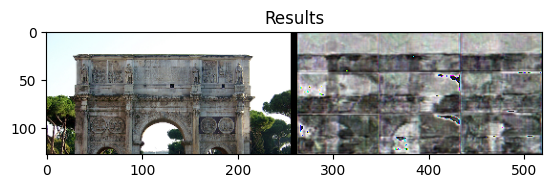

In [ ]:
#this print out results on a picture
PICTURE_NUM = 40 #there are 100 pictures, change to num between 0 - 99 to see other imgs
for p, (pic,label) in enumerate(train_loader2):
  if p == 340:
    pic = pic.to(device)
    label = label.to(device)

    out = model(pic)
    loss = loss_function(out, label)
    pic = torch.squeeze(pic,0)
    out = torch.squeeze(out,0)
    label = torch.squeeze(label,0)

    out = torch.reshape(out,(SHAPE_OUT[1],SHAPE_OUT[2],SHAPE_OUT[0]))
    in1 = torch.reshape(pic,(SHAPE_IN[1],SHAPE_IN[2],SHAPE_IN[0]))
    ilabel = torch.reshape(label,(SHAPE_OUT[1],SHAPE_OUT[2],SHAPE_OUT[0]))

    outc = out.cpu()
    inc = in1.cpu()
    ilabel = ilabel.cpu()
    nout = outc.detach().numpy()
    ninc = inc.detach().numpy()
    nlabel = ilabel.detach().numpy()

    nout = nout.astype(np.uint8)
    ninc = ninc.astype(np.uint8)
    nlabel = nlabel.astype(np.uint8)


    newimg = nout#cv2.resize(ninc, dsize = None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC) + nout
    newimg2 = nlabel# cv2.resize(ninc, dsize = None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC) + nlabel

    newimg = newimg.astype(np.uint8)
    newimg2 = newimg2.astype(np.uint8)

    #newimg = cv2.rotate(newimg, cv2.ROTATE_90_COUNTERCLOCKWISE)
    #newimg2 = cv2.rotate(newimg2, cv2.ROTATE_90_COUNTERCLOCKWISE)
    print(newimg2.shape)
    newimg3 = np.zeros(shape = (128,519,3), dtype = np.uint8)
    for i in range(128):
      for j in range(256):
        newimg3[i][j] = newimg2[i][j]
        newimg3[i][j+263] = newimg[i][j]
    #newimg3[:,:256,:] = newimg
    #newimg3[:,256:,:] = newimg2
    #cv2.imwrite(f'drive/MyDrive/comp_result/compvis_img_{p}.png',newimg3)

    #print(newimg3.shape)

    plt.imshow(cv2.cvtColor(newimg3, cv2.COLOR_BGR2RGB) )
    plt.title('Results')
    plt.show()

    '''
    plt.imshow(cv2.cvtColor(newimg2, cv2.COLOR_BGR2RGB) )
    plt.title('Original')
    plt.show()'''
